# Kontenery
Grupa 4

Problem bazuje na **Projekcie RE:UKRAINE** koncentrując się na tworzeniu tymczasowych rozwiązań mieszkaniowych dla Ukraińców dotkniętych wojną. Projektują modułowe, skalowalne i elastyczne jednostki mieszkalne, które zapewniają godność, komfort i możliwości integracji społecznej. Celem jest szybkie wprowadzenie mieszkań przy użyciu *efektywnych*, kosztowych metod budowy, zachowując przy tym *wysoką jakość*.

<img src="imgs/types.png" width="auto" height="400"/>
<img src="imgs/plan.png" width="auto" height="400"/>

## Opis problemu:
Celem jest zaprojektowanie optymalnego układu kwadratowych kontenerów o jednakowych wymiarach na zadanym obszarze, tak aby:

- Maksymalizować liczbę modułów mieszkalnych
- Zapewnić dostępność do kontenerów sanitarnych, kuchni i przestrzeni wspólnej
- Uwzględnić przestrzeń pustą dla przejść między kontenerami
- Zoptymalizować najkrótszy dostęp do kontenerów sanitarnych, kuchni i przestrzeni wspólnej dla każdego konteneru

## Implementacja

Uwzględniając ułatwienia zdecydowaliśmy się na reprezentację macierzową problemu, ponieważ pozwala to na efektywne modelowanie przestrzennych relacji między elementami budynku. Dzięki tej reprezentacji łatwiej zarządzać różnymi typami pomieszczeń, takimi jak kuchnie, łazienki czy korytarze, oraz ich wzajemnymi powiązaniami. 

### Struktura


Klasa `House` służy do reprezentacji budynku jako macierzy obiektów `Container`, które odzwierciedlają poszczególne segmenty. Każdy `Container` to pojedynczy element budynku, który może pełnić określoną funkcję lub być pustą przestrzenią.

```python
class House:
    '''
    This class represents a 'house' which contains all the Containers of different type. The space is rectangular shape with x width and y height. One cell in matrix represent one container of each type.

    The output of standard __init__ is maze like shape matrix with, all Containers if possible having doors to nearest random neighbor.

    The class have specific kind of attributes:
        * **x**: `width of whole house`
        * **y**: `height of whole house`
        * **houses**: `number of houses containers`
        * **sanitaries**: `number of sanitary containers`
        * **kitchen**: `number of kitchen containers`
        * **halls**: `number of halls containers`
        * **matrix**: `containing matrix with containers`
        * **entrance**: `coordinates of entrance`
    '''
    def __init__(self, x:int ,y:int, matrix=None):
        if x*y < 6:
            raise ValueError('No space for any of the containers')

        self.x = x
        self.y = y
        if matrix is not None:
            if type(matrix) != np.ndarray:
                matrix = np.array(matrix,dtype=Container)
            self.x = matrix.shape[1]
            self.y = matrix.shape[0]
        self.houses = 0
        self.kitchens = 0
        self.sanitaries = 0
        self.halls = 0
        self.ent = None
        if matrix is None:
            self.matrix = self.__generate_maze()
        else:
            self.matrix = self.__generate_existing(matrix)
```

Klasa `Container` odpowiada za reprezentację pojedynczego elementu w siatce budynku, który może przyjąć różne typy (np. '*K*' - kuchnia, '*S*' - sanitariat, '*H*' - hall) oraz ma dodatkowe informacje związane z tym blokiem jak *id* czy na której krawędzi są *drzwi*.

```python
class Container:
    '''
    It is a base container of the building, it is 3m x 3m.

    it **ONLY** has 5 type 'K', 'S', 'C', 'H', '0':
        * K - kitchen
        * S - sanitary
        * C - halls (aka common)
        * H - house
        * 0 - empty space

    All the types except 'empty space' has doors that points to a different empty space. If you will provide doors to the empty space ``ValueError`` will be raised.
    '''
    def __init__(self, id:int,type:str, door = None):
        self.type = type
        self.id = id

        if type == '0' and door is not None:
            raise ValueError(f'Empty space cannot have doors: {door}')
        self.door = door

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        '''
        Representation looks like this i show at bottom, except ``'0'`` which doesnt have door
        :return: type/id>door
        '''
        if self.type != '0':
            return f"{self.type}/{self.id}>{'_' if self.door is None else self.door}"
        else:
            return f"{self.type}/{self.id}"
```

### Operatory


Nasza reprezetacja wymagała zedfiniowania specjalnych operatorów krzyżowania oraz mutacji. Wpływają one w różny sposób na topologię mapy:

* `mutate_individual(house)` &mdash; to mutacja, która losowo zmienia typ jednego kontenera w macierzy budynku. Wybierany jest losowy kontener, a jego typ zmienia się na jeden z dostępnych typów (oprócz obecnego)

* `mutate_rotate_segment(house)` &mdash; mutacja obraca o 90 stopni fragment kwadratowej macierzy segmentu, zachowując jednocześnie pozycje kontenerów o typie '0' (np. drogę)

* `mutation_row_or_column(house)` &mdash; Mutacja, która losowo zmienia całą wybraną linię (wiersz lub kolumnę) w macierzy

* `mutate_add_road(house)` &mdash; Mutacja, która dodaje drogę lub mieszkanie do macierzy budynku. Nowa droga musi być sąsiadująca z już istniejącą drogą

* `mutation_special_containers(house)` &mdash; Mutacja losowo wybiera specjalne kontenery, zmieniając jego typ na któryś z pozostałych

* `mutation_change_doors(house)` &mdash; Mutacja losowo wybiera specjalny kontener lub mieszkanie po czym losowo wybiera ściankę na której będą drzwi (poza aktualną)

* `crossover_swap_row_or_column(house1, house2)` &mdash; Crossover, który zamienia losową linię (wiersz lub kolumnę) między dwoma rodzicami, przy czym kontenery o typie '0' są ignorowane

* `crossover_chessboard(house1, house2)` &mdash; Crossover, który zamienia komórki między dwoma rodzicami w sposób przypominający wzór szachownicy, ignorując kontenery o typie '0'

* `crossover_diagonal(house1, house2)` &mdash; Crossover, który zamienia wartości na przekątnej głównej lub pobocznej między rodzicami, ignorując kontenery o typie '0'


### Funkcja dopasowania


Została zdefiniowana uwzględniając
- średnią odległość pomiędzy pomieszczeniami (kuchnia, sanitariat, przestrzeń wspólna)
- dostępność kontenerów oraz łączność podgrafów.
- ilość segmentów domowych na całe mieszkanie


> Dodatkowo zdefiniowany został system kar za złą topologie budynku. Funkcja <span style="color: red;">karze za niepołączone części budynku i niedostępne kontenery</span>. Na koniec, <span style="color: red;">w zależności od niskiej liczby mieszkań, przyznaje kolejną karę</span>. Funkcja **zwraca sumę wszystkich kar jako miarę jakości rozwiązania**.

## Wizualizacja


Do łatwiejszej interpreacji wyników powstała funkcja `visualize(house)`, tworzy graficzną reprezentację macierzy (domu) z różnymi typami kontenerów. Wizualizuje układ kontenerów, w tym opcjonalnie identyfikatory kontenerów oraz umiejscowienie drzwi między sąsiednimi kontenerami. Każdemu typowi kontenera przypisywany jest określony kolor, a drzwi rysowane są między sąsiadującymi kontenerami.

<div align="center">
    <img src="imgs/visualization2.png" width="auto" height="400"/>
</div>


## Importy

Do obliczeń ewolucyjnych skorzystaliśmy z **Deap'a** ponieważ wspiera on definiowanie własnych operatorów, co umożliwia dostosowanie algorytmów ewolucyjnych do specyficznych potrzeb. Pozwala to na tworzenie niestandardowych operatorów selekcji, mutacji, krzyżowania i funkcji oceny dopasowania.

In [5]:
import random

from deap import base, creator, tools

from representation import House
import operators as op
from visualization import visualize
from loss_functions import loss_function2

## Ustawienie danych

Rejestrujemy nasze specjalnie zdefionwane funkcje w toolboxie dostępnym w Deapie.

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizing fitness
creator.create("Individual", list, fitness=creator.FitnessMin)  # Defining individual with fitness

toolbox = base.Toolbox()

def generate_house():
    rows, cols = 6, 6
    house = House(rows, cols)  # Create a house
    individual = creator.Individual([house])  # Create individual with the house inside
    loss = loss_function2(individual)
    individual.fitness.values = loss  # Evaluate fitness for the individual
    return individual

# ========pierdoły========
toolbox.register("individual", generate_house)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", loss_function2)

#========crossover========
toolbox.register("mate", op.crossover_swap_row_or_column)
#toolbox.register("mate", op.crossover_chessboard)
#toolbox.register("mate", op.crossover_diagonal)
# ========mutation========
toolbox.register("mutate1", op.mutation_row_or_column)
toolbox.register("mutate2", op.mutate_individual)
toolbox.register("mutate3", op.mutate_rotate_segment)
toolbox.register("mutate4", op.mutation_change_doors)
toolbox.register("mutate5", op.mutation_special_containers)
toolbox.register("mutate", op.mutate_add_road)
# ========select========
toolbox.register("select", tools.selTournament, tournsize=9)
#toolbox.register("select", tools.selBest)
#toolbox.register("select", op.sel_roulette_inverted)

In [3]:
CROSS_OVER_P = 0.8
MUTATION_MAIN_P = 0.6
MUTATION_ADDITIONAL_P = 0.25

Wartość celu: 72.25308641975309


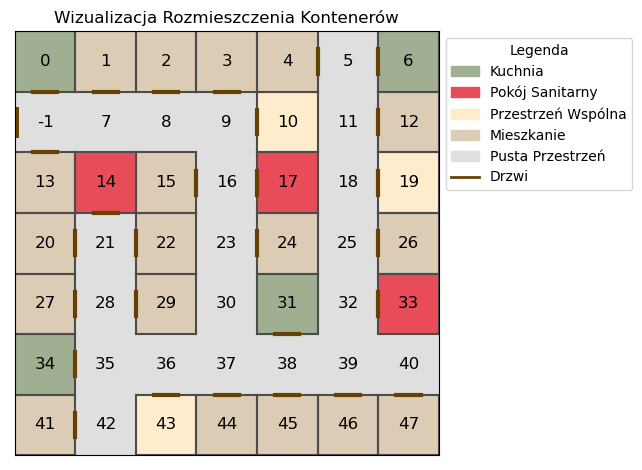

In [4]:
# Algorytm ewolucyjny
def run_algorithm():
    population = toolbox.population(n=200)
    for generation in range(100):  # Liczba generacji
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Krzyżowanie i mutacja
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSS_OVER_P:  # Prawdopodobieństwo krzyżowania
                toolbox.mate(child1, child2)
            if random.random() < MUTATION_MAIN_P:
                toolbox.mutate(child1)
                toolbox.mutate(child2)
            if random.random() < MUTATION_ADDITIONAL_P:
                toolbox.mutate1(child1)
                toolbox.mutate1(child2)
            if random.random() < MUTATION_ADDITIONAL_P:
                toolbox.mutate2(child1)
                toolbox.mutate2(child2)
            if random.random() < MUTATION_ADDITIONAL_P:
                toolbox.mutate3(child1)
                toolbox.mutate3(child2)
            if random.random() < MUTATION_ADDITIONAL_P:
                toolbox.mutate4(child1)
                toolbox.mutate4(child2)
            if random.random() < MUTATION_ADDITIONAL_P:
                toolbox.mutate5(child1)
                toolbox.mutate5(child2)

        # Ocena nowego pokolenia
        for ind in offspring:
            ind.fitness.values = loss_function2(ind)

        # Selekcja najlepszych osobników
        population[:] = tools.selBest(offspring, len(population))

    # Zwróć najlepszego osobnika
    best_individual = tools.selBest(population, 1)[0]

    return best_individual

# Uruchomienie algorytmu
best_house = run_algorithm()

# Selecting the best individual
print(f"Wartość celu: {best_house.fitness.values[0]}")
visualize(best_house[0], showIDs=True)

# Komentarz doświadczeń
## Krzyżowanie
W zasadzie przeprowadziliśmy ich dużą ilość zacznijmy od operatorów krzyżowania:
- wszystkie dają bardzo podobne efekty
- zobaczymy, że jest to mało istotny czynnik tutaj większą rolę odgrywa selekcja z mutacją
## Mutacja
- najważniejszą role odgrywa tutaj `add_road`, które zmienia topologię całego budynku
- reszta mutacji wprowadza pewną wariację, bo albo zamieniają one drzwi, albo zmianiają segmenty miejscami
## Selekcja
- Najlepiej poradziła sobie metoda selekcji turniejowej
- Selekcje typu `SelWorst` oraz `SelRoulette` poradziły sobie znacznie gorzej, przypuszczamy, że to dlatego, że do tego typu zadań nie można bazować tylko na najlepszych osobnikach, ale czesto biorąc najlepszego wpadamy w lokalne minimum(topologi) i nastepnie minimalizujemy ilość domów i potem algorytm nie może z tego wyjść
- Metoda turniejowa, bierze więc taki złoty środek, bo zachowamy "uśrednione najlepsze cechy"

# Doświadzczenia


## Przykład użycia ruletki (odwrócona)
Razem ze wszystkimi 'najlepszym' wyborem mutacji oraz krzyżowania (optymalnie).

<img src="imgs/myplot1.png" width="auto" height="400"/>

## SelWorst
Działa podobnie źle ...

<img src="imgs/myplot2.png" width="auto" height="400"/>

## Przykład wszystkich crossovery
Jak widać wyniki są bardzo do siebie zbliżone z naprawdę drobnymi różnicami.

<img src="imgs/chessboard.png" width="auto" height="200"/>
<img src="imgs/swap.png" width="auto" height="200"/>
<img src="imgs/diagonal.png" width="auto" height="200"/>

## Brak Mutacji topologicznej
<img src="imgs/no_road.png" width="auto" height="400"/>

## Przykład niskiej populacji
Dla małych populacji algorytm nie działa dobrze, potrzebuje on dużo przykładów, które będzie porównywał i modyfikował.

<img src="imgs/low_pop.png" width="auto" height="400"/>

Testowaliśmy również inne zestawienia wartości prawdopodobieństwa. Sensowne wyniki otrzymywaliśmy dla prawdopodobieństwa mutacji topologicznej wyższej lub równej 0.5. Podczas testów prawdopodobieństwo oscylowało z zadowalającymi wynikami dla wartości 0.8. Dla 100 epok osiągaliśmy optymalne wyniki, poniżej tej liczby był problem ze zbieżnością.